<a href="https://colab.research.google.com/github/saurabhmathur96/Speech-to-Text-Engine/blob/master/timit_conditioned_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install soundfile

In [5]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import zipfile

zipfile.ZipFile('My Drive/darpa-timit-acousticphonetic-continuous-speech.zip').extractall('..')

In [0]:
from pathlib import Path
import soundfile as sf 
from tqdm.auto import tqdm




def read_speech(base):
  signals = []
  targets = []
  accents = []
  sexes = []
  base = Path(base)
  for i, accent in tqdm(enumerate(base.iterdir())):
    for speaker in accent.iterdir():
      for f in speaker.iterdir():
        if f.suffix == '.wav':
          signal, rate = sf.read(f)
          signals.append(signal)

          target_file = f.name.replace('.WAV.wav', '.TXT')
          target_path = speaker / target_file
          words = open(target_path).read().strip().split(' ')[2:]
          target = ' '.join(words).lower().replace('.', '').replace(',', '').replace(' -- ', ' ').replace('-', ' ').replace('?', '').replace('"', '').replace('!', '').replace(':', '').replace(';', '')
          targets.append(target)
          accents.append(i)
          sexes.append(['M', 'F'].index(speaker.name[0]))
  return signals, targets, accents, sexes


In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
from tqdm.auto import trange, tqdm


class SpeechData(torch.utils.data.Dataset):
  def __init__(self, inputs, input_lengths, outputs, output_lengths):
    self.inputs = inputs
    self.input_lengths = torch.Tensor(input_lengths)
    self.outputs = outputs
    self.output_lengths = torch.Tensor(output_lengths)
    
    self.n = len(inputs)
  
  def __len__(self):
    return self.n
  
  def __getitem__(self, i):
    inp = self.inputs[i]
    inp_len = self.input_lengths[i]
    op = self.outputs[i]
    op_len = self.output_lengths[i]
    return inp, inp_len, op, op_len

#
# Training data
#
s, t, accents, sexes = read_speech('../data/TRAIN')
chars = set(''.join(t))
char2index = { c: i+2 for i, c in enumerate(chars) }
char2index['<'] = 0
char2index['>'] = 1
print (char2index)

inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y, a, s in tqdm(zip(s, t, accents, sexes), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  a = F.one_hot(torch.tensor([a]*len(inp)), num_classes=8).float()
  s = F.one_hot(torch.tensor([s]*len(inp)), num_classes=2).float()
  inp = torch.cat([inp, a, s], 1)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 

train_data = SpeechData(inputs, input_lengths, outputs, output_lengths)


#
# Test data
#
s, t, accents, sexes = read_speech('../data/TEST')
inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y, a, s in tqdm(zip(s, t, accents, sexes), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  a = F.one_hot(torch.tensor([a]*len(inp)), num_classes=8).float()
  s = F.one_hot(torch.tensor([s]*len(inp)), num_classes=2).float()
  inp = torch.cat([inp, a, s], 1)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 
test_data = SpeechData(inputs, input_lengths, outputs, output_lengths)

{'w': 2, 'q': 3, 'o': 4, 'p': 5, ' ': 6, 'u': 7, 'v': 8, 'f': 9, 'b': 10, 'c': 11, 'h': 12, 'g': 13, 'e': 14, 's': 15, 'i': 16, 'k': 17, 'l': 18, 'm': 19, 'x': 20, 'a': 21, 'd': 22, 'r': 23, 'z': 24, 'n': 25, 'j': 26, "'": 27, 't': 28, 'y': 29, '<': 0, '>': 1}


In [50]:
test_data[600][0][0][-8:]

tensor([0., 0., 1., 0., 0., 0., 0., 0.])

In [80]:
test_data[0][0].shape

torch.Size([118, 523])

In [0]:
class SpeechNet(nn.Module):
  def __init__(self, device, input_size=513, output_size=len(char2index)+1, num_layers=1, hidden_size=1024):
    self.device = device
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    super(SpeechNet, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    h = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    c = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    output, (h, c) = self.lstm(x, (h,c))
    # print (h.shape, c.shape)
    out = self.linear(output)
    return torch.nn.functional.log_softmax(out, 2)
  

def collate(batch):
  inp, inp_len, op, op_len = zip(*batch)
  inp = torch.nn.utils.rnn.pad_sequence(inp, batch_first=True, padding_value=len(char2index))
  inp_len = torch.stack(inp_len)
  op = torch.cat(op) # torch.nn.utils.rnn.pad_sequence(op, batch_first=True, padding_value=len(char2index))
  op_len = torch.stack(op_len)
  return inp, inp_len, op, op_len 


import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, collate_fn=collate)

In [82]:
from torch.autograd import Variable
from tqdm.auto import tqdm
import itertools


device = torch.device('cuda')

net = SpeechNet(device, input_size=523).to(device)
net.apply(weight_init)
clip_value = 1.0
# for p in net.parameters():
#   p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

clip_value = 1.0
criterion = nn.CTCLoss(blank=len(char2index), zero_infinity=True, reduction='none').to(device) #blank=0, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []
test_loss = []
for epoch in range(10):
  for inp, inp_len, op, op_len in tqdm(train_loader):
    
    inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
    op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)

    optimizer.zero_grad()
    
    p = net(inp)
    
    loss = criterion(p.transpose(0,1), op, inp_len, op_len)
    # loss[loss == float("Inf")] = 0
    # print (loss.mean())
    
    loss = loss.mean()
    losses.append(loss.item())

    # torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
    loss.backward()
    optimizer.step()
  print ('train loss = ', np.mean(losses[::-1][:len(train_loader)]))
  
  
  with torch.no_grad():
    for inp, inp_len, op, op_len in tqdm(test_loader):
        
        inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
        op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)
        p = net(inp)
        
        loss = criterion(p.transpose(0,1), op, inp_len, op_len)
        
        loss = loss.mean()
        test_loss.append(loss.item())
    print ('test loss = ', np.mean(test_loss[::-1][:len(test_loader)]))

    index2char = dict(zip(char2index.values(), char2index.keys()))
    for pi in p:
      for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
        if i < len(index2char):
          print (index2char[i], end = '')
      print ()

train loss =  143.20385826373922


test loss =  127.35900562214401
<rrrs
<srssssss
<  rsres rr
<srrr
<s      ra r s ss sra s
< r 
<rrsrrsr
<s s srs
<a r r sras rr
<es   rs
< ssrs
<o s srsss
< 
< s rssssss
<s
<r r  s rr


train loss =  111.99298895474138


test loss =  96.66287807248673
<pro pa to pafo>pe cais> 
<he a r ca co oras loswrsu> 
<r r o is aporr> 
<she had yur dark s bin greasy wash water al yar> 
<h shs n ie w be taa ors> 
<e ien a esata i maaii i iffhohe ta abe iafhos>
< woa br ra ts esraar> 
<he bo porpisma so pcs> 
<sh ora a ou wor  his masshai oii> 
<ha mos po r wa oyasta> 
<shhead yur dark suit on grasy wash water al year> 
<r isan msis hator in s ie ia basis> 
<osk me ou tr an oy rag lik ha> 
<sraia cspa ie ha oco i ba i ia> 
<she ad you dk s i gmesy wash war a ye> 
<h cr he ci ers ha ho wo o ba wary a to boe> 


train loss =  88.02100609088767


test loss =  82.90450459606242
<to fritli ispgrash tiehe a oiyrestololsge en> 
<wote hotaci re dan 
<hots cao hin ca an oti co bats ben blch po> 
<shn fo oudonieriesitotprtos> 
<he es bins moie ressa nor ors> 
<she hd your dark suit in greasy wash water all yea> 
<e hou hari esttin datr iosinsprofo as> 
<to pon mo h grens>n  lor a> 
<he coe ie din  fo e>>e os aswera> 
<the c wan ie bowiti wo> 
<he bi ti co ba s> 
<sbes ol as tlorsis ras ne o osi is frmti n brs> 
<dhesantedinfrs be bos sthiri din anoi> 
<osi s iai a t i r ca des> 
<ot ay dos sporiytors wir ma>he jin inti tii bisto o degrchs>
<hi cls som td attiri t> 


train loss =  77.62305279435783


test loss =  76.61597615367961
<tee spinti sh taciya cresstrf roaso>t
<riseto dl as a bo re la clot>
<ols o ae bote  wr li o to brethesns tower>
<she had your dark suit in greasy wash water all year> 
<hestol a oing bo lh a ger
<oto t mad af tra tei ae>
<frin is pe stet ea a nires he lostto>
<thes prns os toit cusiha  borcrotidaion o orswlls n aa>
<a e gan tes trslati otin i fos bl domatofers ahattiha>
<the canmbr bo de s gr teran o>
<he radasan tse he t pla
<jeah feryour rar e n aer as santo heur t prtos>
<sto ass ca oof vasion the s >
<do fres dastee i layres tolostcon l>
<don't ask me to carry an oily rag like that>
<athitat he e gat gi thesigers to clts>


train loss =  71.24782325481546


test loss =  73.84424763805461
<she had your dark suit in greasy wash water all year>
<she aftficsi r in in fier eis antfeceprtis>
<the tu firif fer uti com len hois sto fil o
<atisisyoldtaligeyons his fr ri>
<dinye rearn shild min dacerithir clsernswrl olidhas>
<mng s tfron ly doislge s captetose a s>
<he patin hati greadhes arav rcracxstin inthe be den ple lo>
<dhet bag re an sis wlly ar a ste>
<thi dclsi hang die thrlatori like this>
<the clos re an the a proptera> at bieshel
<thi scne da o hii igraov acrssy biasistingssir rag tacne >
<doery a hostiry averaei
<talsim ma t bones in tysscrm>
<doat me s me  be opouine cor mttscrsrurt>
<the ly loryrs lofetheyinhaers>
<ther poied rosthn n masshith rech l lusr antsthem morhutituje an>


train loss =  65.224718291184


test loss =  71.51133087446105
<hou wah is wais an oros> 
<lctopbi lryoerfis the tpaalesae valpol tat o er merfrpration> 
<onappi fors  he bot ae for  gro> 
<e tores are r conthenin forqrei lotch> 
<ea tingspatisnot lay  in cresiscr riccols>
<ra ot ar era rein in ati cas> 
<she had your dark suit in greasy wash water all year> 
<ie slly athes fo nat ari loe r> 
<she encren is aplyt hile loman lolowen>  
<at av a capic as as anstas a nos n woversi ta pats> 
<on't ask me to carry an oiily rag like that>
<es th clasinfo he asir> 
<he tiis nmas fom his for a dthid ther> i he spacti lein>o costhe thac>
<mno he manm was note cromhe won gar hat y ha ta o ith histran> 
<don't ask me to carry an oily rag like that> 
<non't ask me to cary an oily rag like that>  


train loss =  59.67875282024515


test loss =  70.90188620225439
<tefh ogheolageyu in fi erthe semti ee brhians> 
<the tai l y flb lel reponnlos a> 
<diye geardsghildren dacperiter clasures frol oladt es>
<do mety atxspurttesthis cane was an nevblt a ble> 
<she had your dark suit in greasy wash water all year> 
<then bgrand mak ancs la lay apter mice sthat> 
<don't ask me to carry an oily rag like that> 
<at tlee an as lalf tay l uf ioubly 
<we worke r cn susd nle recscerte on blls ns> 
<the you pao averta piamion> 
<the om mone bh pastharoplela olaplal> 
<she had your dark suit in greasy wash water all year> 
<a shels in fewe be amjinbrs> 
<ton't ask me to carry an oily rag like that> 
<her vlother aut prover oub peran ing ein atie as> 
<aot as me to carry an oily rag like that> 


train loss =  53.8364832384833


test loss =  69.97493873452241
<wether prs  go oishis or vhery ou s foln she te> 
<seyou wayersuhfhit clating ol beasnteeres> 
<don't ask me to carry an oily rag like that> 
<she astaner hn heiannm 
<tont ask me to carry an oily rag like that> 
<the dolblols so comters in mo bervhothe alideas> 
<he gonn an captes tetopaer o dop plinpo thros> 
<e de phe roveraie fhaperea e dol ly  lak nmatol> 
<she had your dark suit in greasy wash water all year> 
<ha all o wre i oer sey o oms> 
<thelha oor fo won gal a has> 
<she had your dark suit in greasy wash water all year> 
<his strowy every fwre r leded to m odis> 
<in factur molldhe fems i en a thiga jeb 
<don't ask me to carry an oily rag like that> 
<she had your dark suit  an reasy wash water all year>


train loss =  47.669743347167966


test loss =  70.80175097483509
<ther mor athese mee fom madyason teini prbeid lieseers>
<thesh shuoldbers odhers if hat wor bro en
<stra adds uare otof fashon ais sueare> 
<hep ples  et atad bever thentluich sheup is a letmen>
<don't ask me to carry an oily rag like that>
<the cor yourdtes mahnethisim ly decraiid id>
<spro ats orourt of vasching is er>
<mine tle sesidty ish dbate ton hiror ose>
<the too hari fo atti comeon mrargers t thet>
<don't ask me to carry an oily rag like that>
<surthe coloe wo o ofttr a teor o>
<thon'ne sets oe comedantandeas cres>
<don't ask me to carry an oily rag like that>
<aner ordnteld ern aec uraght er cafurn's fra holdhys>
<ton't ask me to carry an oily rag like that> 
<she had your dark suit in greasy wash water all year> 


train loss =  41.50283154454725


test loss =  72.92102864103497
<a roethe seubble a bea havea nhe nuh chands> 
<uspaires bisi fechoereing ike rean graps> tater daranderean>
<hen mase suiet at hs promblen rspa mawost> at taheeretysecrernt> 
<hopgrae to pake apaker ther tad ors>  
<the curol cos to tol auveraeage fort hetin a t> 
<heolf contro bes stlap ar for the plye res> 
<hisws  fol by woe an onteinses> 
<ti you baany cordgeray overls> 
<thi wls suooet bur a le churise racsong h>  
<don't ask me to carry an oily rag like that> 
<at tond you caot outto ploe> 
<comboin omyave reinsunl ors boll> 
<ht pongeral ws pucinys cigaya biishore> 
<i dhe son r quires proracsll proval fur aderatge marige>  
<she had your dark suit in greasy wash water all year> 
<the denmin captese vice tom corr atompoin tireawrs> 


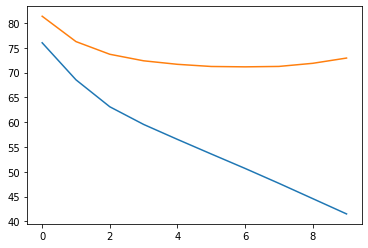

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([np.mean(losses[start:start+len(losses)])  for start in range(0, len(losses), len(train_loader))])
plt.plot([np.mean(test_loss[start:start+len(test_loss)]) for start in range(0, len(test_loss), len(test_loader))])

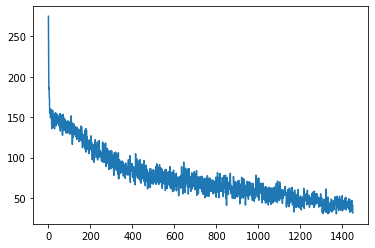

In [87]:
plt.plot(losses)

In [88]:
import itertools
with torch.no_grad():
  for inp, inp_len, op, op_len in test_loader:
      
      inp, inp_len = inp.float().to(device), inp_len.long().to(device)
      op, op_len = op.long().to(device), op_len.long().to(device)

       

      p = net(inp)
      start = 0
      for pi, o in zip(p, op_len):
        
        
        print (''.join(index2char[i] for i in op[start:start+o].cpu().numpy()))
        for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
          
          if i < len(index2char):
            print (index2char[i], end = '')
        print ('\n')
        start += o

<combine all the ingredients in a large bowl>
<ombo atey hreins hal large bo> 

<help greg to pick a peck of potatoes>
<ou bra the paiket pack opetaes> 

<salvation reconsidered>
<follvhacin ma coniderd> 

<the fish began to leap frantically on the surface of the small lake>
<he fisio bdntole firc ally on the surfls ha lhesmoliy c 

<young children should avoid exposure to contagious diseases>
<hent sovern'sutd for hitespasiueto untacies se s ors> 

<don't ask me to carry an oily rag like that>
<don't ask me to carry an oily rag like that>

<we can die too we can die like real people>
<he con dneane sowle henoaqrl epl> 

<are your grades higher or lower than nancy's>
<a goue crate or rloed in nansis> 

<cory and trish played tag with beach balls for hours>
<cryantreti cae tand ite bete boowsoronse> 

<planned parenthood organizations promote birth control>
<flran tranto a or uos aions pro brst atoal> 

<cliff was soothed by the luxurious massage>
<clee wale suoe ba le to  tous bhe sord